In [2]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import torch
import pickle
from scipy.stats import binned_statistic

In [3]:
LABELS = '/media/iafoss/New Volume/ML/G2Net2022/data/_labels.csv'
DATA = '/media/iafoss/New Volume/ML/G2Net2022/data/train'
OUT = '/media/iafoss/New Volume/ML/G2Net2022/data/train.pickle'

nbins=128

In [ ]:
def extract_data_from_hdf5(path):
    data = {}
    with h5py.File(path, "r") as f:
        ID_key = list(f.keys())[0]
        # Retrieve the frequency data
        data['freq'] = np.array(f[ID_key]['frequency_Hz'])
        # Retrieve the Livingston decector data
        data['L1_SFTs_amplitudes'] = np.array(f[ID_key]['L1']['SFTs'])
        data['L1_ts'] = np.array(f[ID_key]['L1']['timestamps_GPS'])
        # Retrieve the Hanford decector data
        data['H1_SFTs_amplitudes'] = np.array(f[ID_key]['H1']['SFTs'])
        data['H1_ts'] = np.array(f[ID_key]['H1']['timestamps_GPS'])
    return data

df = pd.read_csv(LABELS)
dataset = {}
for index,row in tqdm(df.iterrows(),total=len(df)):
    idx = row['id']
    target = row['target']
    data = extract_data_from_hdf5(os.path.join(DATA,idx+'.hdf5'))
    time_ids = {'H1':data['H1_ts'], 'L1':data['L1_ts']}
    
    mean_statH = binned_statistic(time_ids['H1'], np.abs(data['H1_SFTs_amplitudes']*1e22)**2,
        statistic='mean', bins=nbins, 
        range=(max(time_ids['H1'].min(),time_ids['L1'].min()),
        min(time_ids['H1'].max(),time_ids['L1'].max())))
    mean_statL = binned_statistic(time_ids['L1'], np.abs(data['L1_SFTs_amplitudes']*1e22)**2,
        statistic='mean', bins=nbins, 
        range=(max(time_ids['H1'].min(),time_ids['L1'].min()),
        min(time_ids['H1'].max(),time_ids['L1'].max())))
    mean_statH = np.nan_to_num(np.transpose(mean_statH.statistic,(0,1)))
    mean_statL = np.nan_to_num(np.transpose(mean_statL.statistic,(0,1)))
    
    n_statH = binned_statistic(time_ids['H1'], np.ones((1,len(time_ids['H1']))), statistic='sum', bins=nbins, 
        range=(max(time_ids['H1'].min(),time_ids['L1'].min()),
        min(time_ids['H1'].max(),time_ids['L1'].max())))
    n_statL = binned_statistic(time_ids['L1'], np.ones((1,len(time_ids['L1']))), statistic='sum', bins=nbins, 
        range=(max(time_ids['H1'].min(),time_ids['L1'].min()),
        min(time_ids['H1'].max(),time_ids['L1'].max())))
    n_statH = np.nan_to_num(n_statH.statistic)[0].astype(int)
    n_statL = np.nan_to_num(n_statL.statistic)[0].astype(int)
    
    dataset[idx] = {'H1':mean_statH,'L1':mean_statL,'H1_ts':n_statH, 'L1_ts':n_statL}

with open('data/gwaves_train_v5.pickle', 'wb') as handle:
    pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
#test data
std_flags, std_est = {},[]
for fname in tqdm([f for f in os.listdir('/media/iafoss/New Volume/ML/G2Net2022/data/test')]):
    fidx = fname.split('.')[0]
    data = extract_data_from_hdf5(os.path.join('/media/iafoss/New Volume/ML/G2Net2022/data/test',fname))
    std_H = np.abs(data['H1_SFTs_amplitudes']*1e22).std()
    std_L = np.abs(data['L1_SFTs_amplitudes']*1e22).std()
    #train min,max,mean: 0.69375944,0.6990975,0.6950916
    f0 = std_H < 0.693 or std_H > 0.700 # find nonstationary noise cases
    f1 = std_L < 0.693 or std_L > 0.700
    std_flags[fidx] = int(f0) + 2*int(f1)
    if f0 == 0 and f1 == 0: continue 
    
    time_ids = {'H1':data['H1_ts'], 'L1':data['L1_ts']}    
    std_H = 0.5*((data['H1_SFTs_amplitudes'].real*1e22).std(0)**2 + 
             (data['H1_SFTs_amplitudes'].imag*1e22).std(0)**2)
    std_statH = binned_statistic(time_ids['H1'], std_H,
            statistic='mean', bins=nbins, 
            range=(max(time_ids['H1'].min(),time_ids['L1'].min()),
            min(time_ids['H1'].max(),time_ids['L1'].max())))
    std_statH = np.nan_to_num(std_statH.statistic**0.5,nan=1.0)
    
    std_L = 0.5*((data['L1_SFTs_amplitudes'].real*1e22).std(0)**2 + 
             (data['L1_SFTs_amplitudes'].imag*1e22).std(0)**2)
    std_statL = binned_statistic(time_ids['L1'], std_L,
            statistic='mean', bins=nbins, 
            range=(max(time_ids['H1'].min(),time_ids['L1'].min()),
            min(time_ids['H1'].max(),time_ids['L1'].max())))
    std_statL = np.nan_to_num(std_statL.statistic**0.5,nan=1.0)
    
    n_statH = binned_statistic(time_ids['H1'], np.ones((1,len(time_ids['H1']))), statistic='sum', bins=nbins, 
        range=(max(time_ids['H1'].min(),time_ids['L1'].min()),
        min(time_ids['H1'].max(),time_ids['L1'].max())))
    n_statL = binned_statistic(time_ids['L1'], np.ones((1,len(time_ids['L1']))), statistic='sum', bins=nbins, 
        range=(max(time_ids['H1'].min(),time_ids['L1'].min()),
        min(time_ids['H1'].max(),time_ids['L1'].max())))
    n_statH = np.nan_to_num(n_statH.statistic)[0].astype(int)
    n_statL = np.nan_to_num(n_statL.statistic)[0].astype(int)
    
    std_est.append({'H1_std':std_statH,'L1_std':std_statL,'H1_ts':n_statH, 'L1_ts':n_statL})

with open('data/real_noise_std.pickle', 'wb') as handle:
    pickle.dump(std_est, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
df_test_std = pd.DataFrame({'id':std_flags.keys(),'std_flag':std_flags.values()})
df_test_std.to_csv('data/test_std.csv',index=False)
df_test_std.head()

  0%|          | 0/7975 [00:00<?, ?it/s]

,id,std_flag
0,00054c878,0
1,0007285a3,0
2,00076c5a6,0
3,001349290,0
4,001a52e92,0


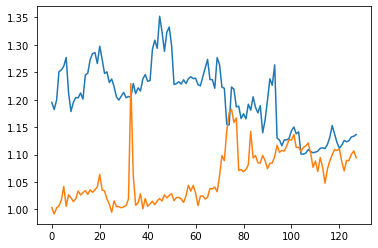

In [18]:
with open('data/real_noise_std.pickle', 'rb') as handle:
    std_est = pickle.load(handle)

i=0
plt.plot(std_est[i]['H1_std'])
plt.plot(std_est[i]['L1_std'])

In [19]:
import os
import h5py
import pickle

paths = ['/media/iafoss/New Volume/ML/G2Net2022/data/train',
         '/media/iafoss/New Volume/ML/G2Net2022/data/test']

def get_ts(idx):
    data = {}
    path = os.path.join(p)
    with h5py.File(path, "r") as f:
        ID_key = list(f.keys())[0]
        data['L1_ts'] = np.array(f[ID_key]['L1']['timestamps_GPS'])
        data['H1_ts'] = np.array(f[ID_key]['H1']['timestamps_GPS'])
    return data

timestamps_all = []
for path in paths:
    for p in tqdm([os.path.join(path,p) for p in os.listdir(path)]):
        timestamps = get_ts(p)
        if len(timestamps['L1_ts']) < 4000 or len(timestamps['H1_ts']) < 4000: continue
        timestamps_all.append(timestamps)

with open('data/timestamps_all.pickle', 'wb') as handle:
    pickle.dump(timestamps_all, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/603 [00:00<?, ?it/s]

  0%|          | 0/7975 [00:00<?, ?it/s]